In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'sample_submission.csv', 'train.csv', 'train']


In [25]:
import numpy as np
import pandas as pd
import imageio as im
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import gc
import glob
import os
import cv2
import random


In [26]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
from IPython.display import Image
from keras.preprocessing import image
from keras import optimizers
from keras import layers,models
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
print(os.listdir("../input"))

import numpy as np

['test', 'sample_submission.csv', 'train.csv', 'train']


In [27]:
train_dir="../input/train/train"
test_dir="../input/test/test"
train=pd.read_csv('../input/train.csv')

df_test=pd.read_csv('../input/sample_submission.csv')

In [28]:
train.head(5)

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [29]:
print('out dataset has {} rows and {} columns'.format(train.shape[0],train.shape[1]))

out dataset has 17500 rows and 2 columns


In [30]:
train['has_cactus'].value_counts(normalize=True)

1    0.750629
0    0.249371
Name: has_cactus, dtype: float64

In [31]:
print("The number of rows in test set is %d"%(len(os.listdir('../input/test/test'))))

The number of rows in test set is 4000


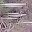

In [32]:
Image(os.path.join("../input/train/train",train.iloc[0,0]),width=250,height=250)

In [33]:
def prepare_data(data,m,direc):
    print('preparing data')
    X_train=np.zeros((m,32,32,3))
    count=0
    for fig in data['id']:
        img=image.load_img(os.path.join(direc,fig),target_size=(32,32,3))
        x=image.img_to_array(img)
        x=preprocess_input(x)
        X_train[count]=x/255
        count+=1
        
        
    print("Done")
    return X_train

In [34]:
data=prepare_data(train,train.shape[0],train_dir)
test=prepare_data(df_test,len(df_test),test_dir)

preparing data
Done
preparing data
Done


In [35]:
train_x=data[:15001]
train_y=train['has_cactus'][:15001]
test_x=data[15001:]
test_y=train['has_cactus'][15001:]

In [40]:
df_test.head(1)

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5


In [41]:

# Input
height = 32
width = 32
channels = 3
n_inputs = height * width * channels

# Parameters for TWO convolutional layers: 

conv3_fmaps = 32
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"

conv1_fmaps = 128
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"

# Define a pooling layer
pool3_dropout_rate = 0.25
pool3_fmaps = conv2_fmaps

# Define a fully connected layer 
n_fc1 = 128
fc1_dropout_rate = 0.5

# Output
n_outputs = 2


tf.reset_default_graph() 

# Step 2: Set up placeholders for input data
with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, 32,32,3], name="X")
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    y_true=tf.argmax(y, dimension=1)
    training = tf.placeholder_with_default(False, shape=[], name='training')

    
# Step 3: Set up the two convolutional layers using tf.layers.conv2d
conv3 = tf.layers.conv2d(X, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.relu, name="conv1")
conv1 = tf.layers.conv2d(conv3, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv2")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv3")

# Step 4: Set up the pooling layer with dropout using tf.nn.max_pool 
with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 16 * 16])
    pool3_flat_drop = tf.layers.dropout(pool3_flat, pool3_dropout_rate, training=training)

# Step 5: Set up the fully connected layer using tf.layers.dense
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

# Step 6: Calculate final output from the output of the fully connected layer
with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")
    y_pred=tf.argmax(Y_proba, dimension=1)

# Step 5: Define the optimizer; taking as input (learning_rate) and (loss)
with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

# Step 6: Define the evaluation metric
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# Step 7: Initiate    
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
# Step 8: Read in data


# Step 9: Define some necessary functions
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

# Step 10: Define training and evaluation parameters
n_epochs = 20
batch_size = 100
iteration = 0

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

# Step 11: Train and evaluate CNN with Early Stopping procedure defined at the very top
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(train_x, train_y, batch_size):
            iteration += 1
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: test_x, y: test_y})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: test_x, y: test_y})
        print("Epoch {}, last batch accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_batch * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break
    if best_model_params:
        restore_model_params(best_model_params)
    prediction= y_pred.eval(feed_dict={X: test})
    save_path = saver.save(sess, "./my_mnist_model")


    


Epoch 0, last batch accuracy: 100.0000%, valid. accuracy: 98.1192%, valid. best loss: inf
Epoch 1, last batch accuracy: 99.0000%, valid. accuracy: 99.1597%, valid. best loss: inf
Epoch 2, last batch accuracy: 99.0000%, valid. accuracy: 99.1997%, valid. best loss: inf
Epoch 3, last batch accuracy: 100.0000%, valid. accuracy: 97.3589%, valid. best loss: 0.021854
Epoch 4, last batch accuracy: 100.0000%, valid. accuracy: 99.5198%, valid. best loss: 0.021854
Epoch 5, last batch accuracy: 100.0000%, valid. accuracy: 99.7199%, valid. best loss: 0.021854
Epoch 6, last batch accuracy: 100.0000%, valid. accuracy: 98.9596%, valid. best loss: 0.020820
Epoch 7, last batch accuracy: 100.0000%, valid. accuracy: 99.5998%, valid. best loss: 0.020820
Epoch 8, last batch accuracy: 100.0000%, valid. accuracy: 99.6799%, valid. best loss: 0.020820
Epoch 9, last batch accuracy: 100.0000%, valid. accuracy: 99.7199%, valid. best loss: 0.020820
Epoch 10, last batch accuracy: 100.0000%, valid. accuracy: 99.3998%

In [44]:
df=pd.DataFrame({'id':df_test['id'] })
df['has_cactus']=prediction
df.to_csv("samplesubmission.csv",index=False)